# scikit-learn-k-means

Credits: Forked from [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas

致谢：派生自 Jake VanderPlas 的 [PyCon 2015 Scikit-learn 教程](https://github.com/jakevdp/sklearn_pycon2015)

In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl

seaborn.set()

## K-Means Clustering K均值聚类

Reduced dataset shape: (150, 2)
Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


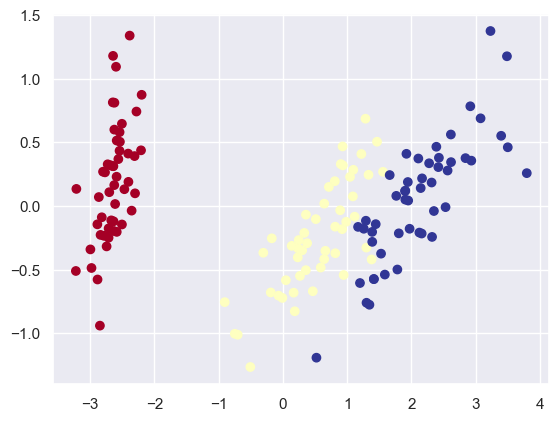

In [2]:
from sklearn import neighbors, datasets

iris = datasets.load_iris()

X, y = iris.data, iris.target
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

import pylab as pl
pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
           cmap='RdYlBu')

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

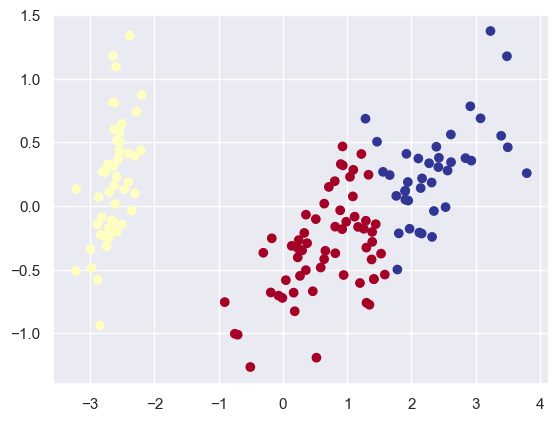

In [3]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(X)
y_pred = k_means.predict(X)

pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred,
           cmap='RdYlBu');

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K 均值是一种**无监督聚类**算法：即仅基于数据属性（而非标签）在数据中查找聚类。

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

K 均值是一种相对容易理解的算法。它搜索聚类中心，这些中心是聚类内点的平均值，使得每个点都最接近它所属的聚类中心。

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

让我们看看 K 均值如何在我们之前研究过的简单聚类上进行操作。为了强调这是无监督的，我们不会绘制聚类的颜色：

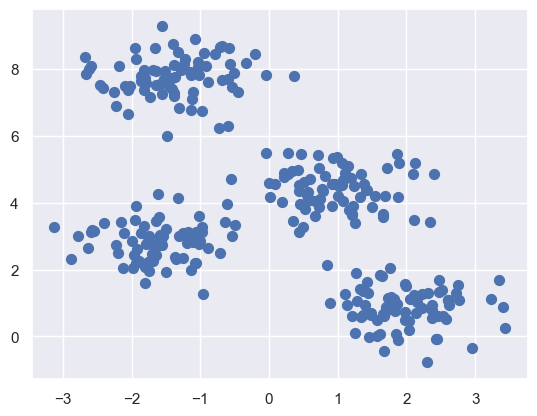

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

肉眼观察，挑选出这四个聚类相对容易。然而，如果对数据的不同分段进行详尽搜索，搜索空间的点数将呈指数级增长。幸运的是，scikit-learn 实现了一个著名的“期望最大化 (EM)”过程，因此 KMeans 可以相对快速地求解。

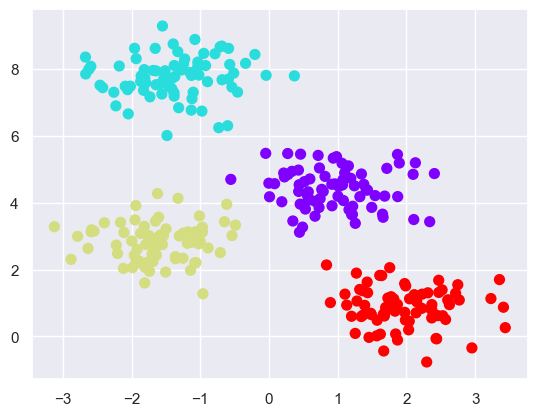

In [5]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

该算法以与我们用眼睛识别的方式非常相似的方式识别四个点簇！

## The K-Means Algorithm: Expectation Maximization
## K-均值算法：期望最大化

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
K-均值是使用 *期望最大化* 方法得出解决方案的算法示例。
*Expectation-Maximization* is a two-step approach which works as follows:
*期望最大化* 是一种两步法，其工作原理如下：

1. Guess some cluster centers  猜测一些聚类中心
2. Repeat until converged 重复直到收敛

    A. Assign points to the nearest cluster center 将点分配到最近的聚类中心

    B. Set the cluster centers to the mean  将聚类中心设置为平均值 
   
Let's quickly visualize this process:

让我们快速可视化这个过程：

In [13]:
def plot_kmeans_interactive(min_clusters=1, max_clusters=5):
    from ipywidgets import interact
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.datasets import make_blobs
    import warnings

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')

        X, y = make_blobs(n_samples=300, centers=4,
                          random_state=0, cluster_std=0.60)

        def _kmeans_step(frame=0, n_clusters=4):
            rng = np.random.RandomState(2)
            labels = np.zeros(X.shape[0])
            centers = rng.randn(n_clusters, 2)

            nsteps = frame // 3

            for i in range(nsteps + 1):
                old_centers = centers
                if i < nsteps or frame % 3 > 0:
                    dist = euclidean_distances(X, centers)
                    labels = dist.argmin(1)

                if i < nsteps or frame % 3 > 1:
                    centers = np.array([X[labels == j].mean(0)
                                        for j in range(n_clusters)])
                    nans = np.isnan(centers)
                    centers[nans] = old_centers[nans]


            # plot the data and cluster centers
            plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow',
                        vmin=0, vmax=n_clusters - 1);
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c=np.arange(n_clusters),
                        s=200, cmap='rainbow')
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c='black', s=50)

            # plot new centers if third frame
            if frame % 3 == 2:
                for i in range(n_clusters):
                    plt.annotate('', centers[i], old_centers[i], 
                                 arrowprops=dict(arrowstyle='->', linewidth=1))
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c=np.arange(n_clusters),
                            s=200, cmap='rainbow')
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c='black', s=50)

            plt.xlim(-4, 4)
            plt.ylim(-2, 10)

            if frame % 3 == 1:
                plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                         ha='right', va='top', size=14)
            elif frame % 3 == 2:
                plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                         ha='right', va='top', size=14)

    
    return interact(_kmeans_step, frame=[0, 50],
                    n_clusters=[min_clusters, max_clusters])

plot_kmeans_interactive()

interactive(children=(Dropdown(description='frame', options=(0, 50), value=0), Dropdown(description='n_cluster…

<function __main__.plot_kmeans_interactive.<locals>._kmeans_step(frame=0, n_clusters=4)>

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats
### K-均值注意事项

* The convergence of this algorithm is not guaranteed; for that reason, by default scikit-learn uses a large number of random initializations and finds the best results.
* 此算法的收敛性无法保证；因此，默认情况下，scikit-learn 使用大量随机初始化并找到最佳结果。

* The number of clusters must be set beforehand.  There are other clustering algorithms for which this requirement may be lifted.

* 必须预先设置聚类数。还有其他聚类算法可以取消此要求。